In [1]:
import snap

# 1. Network Characteristics

## Erdos-Renyi Random graph (G(n, m) random network)
Generate a random instance of this model by using n = 5242 nodes and picking m = 14484 edges at random.

In [4]:
# Generate a random undirected instance of Erdos-Renyi Random graph ( by using n = 5242 nodes and picking m = 14484 edges at random
import random

def genErdosRenyi(N=5242, E=14484):     
    # 랜덤 시드는 고정
    random.seed(2020)
    
    # edge 개수에 상응하는 p를 계산해야 한다. 

    # 아무 연결이 없는 노드들을 생성한다.
    G = snap.TUNGraph.New()
    for i in range(N):   # 노드는 0부터 시작
        G.AddNode(i)

    # random하게 두 노드를 선택하여 연결
    # 충분한 연결선이 확보될 때까지 반복
    edges = set()
    n_edge = 0
    while n_edge < E:
        pick_nodes = tuple(sorted(np.random.choice(N, 2, replace=False).tolist()))  # undirected를 고려해서 sort
        if pick_nodes not in edges:
            edges.add(pick_nodes)
            n_edge += 1
    
    # 생성된 edge를 그래프에 추가
    for edge in edges:
        G.AddEdge(edge[0], edge[1])

    return G


G1 = genErdosRenyi()
assert G1.GetEdges() == 14484

## Small-World Random Network: 
Generate an instance from this model as follows: begin with n = 5242 nodes arranged as a ring, i.e., imagine the nodes form a circle and each node is connected to its two direct neighbors (e.g., node 399 is connected to nodes 398 and 400), giving us 5242 edges. Next, connect each node to the neighbors of its neighbors (e.g., node 399 is also connected to nodes 397 and 401). This gives us another 5242 edges. Finally, randomly select 4000 pairs of nodes not yet connected and add an edge between them. In total, this will make m = 5242 · 2 + 4000 = 14484 edges

In [6]:
def genCircle(N=5242):
    """
    :param - N: number of nodes

    return type: snap.PUNGraph
    return: Circle graph with N nodes and N edges. Imagine the nodes form a
        circle and each node is connected to its two direct neighbors.
    """
    ############################################################################
    # TODO: Your code here!
    nodes = []
    edges = set()
    
    # 아무 연결이 없는 노드들을 생성한다.
    for i in range(N):   # 노드는 0부터 시작
        nodes.append(i)

    # 양 이웃 노드랑 연결한다.   i-1  <--  i --> i+1
    for i in range(N):
        left = N-1 if i == 0 else i-1
        right = 0 if i == N-1 else i+1
        edges.add((i, left))
        edges.add((i, right))
        
    # friend of friend 연결을 생성한다. i-2 <-- i --> i+2
    for i in range(N):
        if i == 0:
            left, right = N-2, i+2
        elif i == 1:
            left, right = N-1, i+2
        elif i == N-2:
            left, right = i-2, 0
        elif i == N-1:
            left, right = i-2, 1
        else:
            left, right = i-2, i+2
            
        edges.add((i, left))
        edges.add((i, right)) 
    
    # randomly select 4000 pairs of nodes not yet connected and add an edge between them
    random_edges = set()
    n_edge = 0
    n_max = 4000
    while n_edge < n_max:
        n1 = np.random.choice(N)
        n2 = np.random.choice(N)
        if n1 != n2 and (n1,n2) not in random_edges and (n1,n2) not in edges:
            edges.add((n1,n2))
            n_edge += 1    

    G = snap.TUNGraph.New()
    for i in range(N):   # 노드는 0부터 시작
        G.AddNode(i)        
    for edge in edges:
        G.AddEdge(edge[0], edge[1])   
    
        
    return G
G2 = genCircle()
#assert G2.GetEdges() == 14483
G2.GetEdges()

14483

## Real-World Collaboration Network
* represent authors of research papers on the arXiv in the General Relativity and Quantum Cosmology section
* remove duplicates and self-loops

In [7]:
G3 = snap.LoadEdgeList(snap.PUNGraph, 'ca-GrQc.txt', 0, 1, '\t')
snap.DelSelfEdges(G3)

assert G3.GetEdges() == 14484

## Plot the degree distribution of all three networks in the same plot on a log-log scale

In [8]:
import numpy as np
import matplotlib.pyplot as plt
def plot_deg_dist(G, graph_name, log_scale=True):
    # get out-degree distribution
    degOutCntV = snap.TIntPrV()
    snap.GetOutDegCnt(G, degOutCntV)
    x = [cnt.GetVal1() for cnt in degOutCntV if cnt.GetVal1() >= 1]
    y = [cnt.GetVal2() for cnt in degOutCntV if cnt.GetVal1() >= 1]
    if log_scale:
        x_scaled, y_scaled = np.log(x), np.log(y)
    else:
        x_scaled, y_scaled = x, y

    # plot out-degree distribution
    f, ax = plt.subplots(figsize=(10,5))
    plt.plot(x_scaled, y_scaled, linewidth=2.5, color='navy')
    plt.xlabel(r'# of out-degree (log-scale)')
    plt.ylabel(r'# of node counts (log-scale)')
    ax.grid(True)
    plt.title(f'degree distribution of {graph_name} on a log-log scale')
    plt.show()

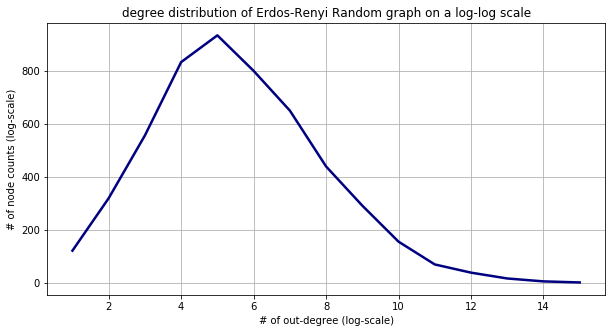

In [9]:
plot_deg_dist(G1, 'Erdos-Renyi Random graph', log_scale=False)

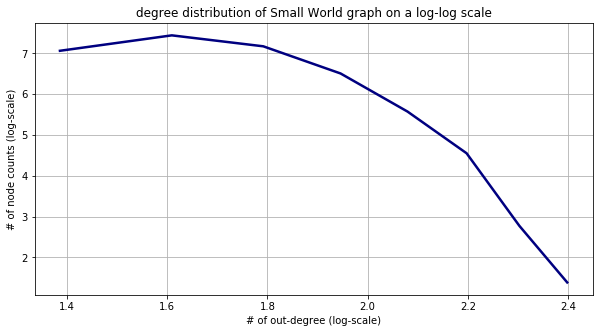

In [10]:
plot_deg_dist(G2, 'Small World graph', log_scale=True)

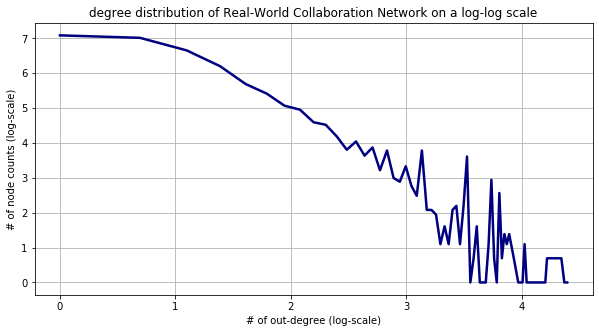

In [11]:
plot_deg_dist(G3, 'Real-World Collaboration Network', log_scale=True)

## 1.2 Clustering Coefficient 

In [12]:
def calcClusteringCoefficientSingleNode(Node, Graph):
    """
    :param - Node: node from snap.PUNGraph object. Graph.Nodes() will give an
                   iterable of nodes in a graph
    :param - Graph: snap.PUNGraph object representing an undirected graph

    return type: float
    returns: local clustering coeffient of Node
    """
    ############################################################################
    # TODO: Your code here!
    C = 0.0
    ki = Node.GetDeg()
    
    # get all neighbor node ids from the central node
    neighrbor_nodes = [ neighborId for neighborId in Node.GetOutEdges() ]
    
    # get all neigbor nodes' edges and check if that is connected to neigborbor of central node
    ei = 0  # edge between neighbors    
    for neighborId in neighrbor_nodes:
        neighborNodeI = Graph.GetNI(neighborId)
        for dstId in neighborNodeI.GetOutEdges():
            if dstId in neighrbor_nodes:
                ei += 1
            
    if ki >= 2:
        C = 2* ei / ki*(ki-1)
    else:
        C = 0
    
    ############################################################################
    return C

def calcClusteringCoefficient(Graph):
    """
    :param - Graph: snap.PUNGraph object representing an undirected graph

    return type: float
    returns: clustering coeffient of Graph
    """
    ############################################################################
    # TODO: Your code here! If you filled out calcClusteringCoefficientSingleNode,
    #       you'll probably want to call it in a loop here
    C = 0.0
    n_node = Graph.GetNodes()
    for NI in Graph.Nodes():
        C += calcClusteringCoefficientSingleNode(NI, Graph)
    C = C / n_node
        
    ############################################################################
    return C

In [13]:
print(f'Clustering cofficient of Erdos-Renyi Random graph = {calcClusteringCoefficient(G1)}')

Clustering cofficient of Erdos-Renyi Random graph = 0.0659318446613372


In [14]:
print(f'Clustering cofficient of small world network = {calcClusteringCoefficient(G2)}')

Clustering cofficient of small world network = 9.726776072712541


In [15]:
print(f'Clustering cofficient of Real-World Collaboration Network = {calcClusteringCoefficient(G3)}')

Clustering cofficient of Real-World Collaboration Network = 105.0590039620891


# 2 Structural Roles: Rolx and ReFex 

## 2.1 Basic Features

In [16]:
G2 = snap.TUNGraph.Load(snap.TFIn("hw1-q2.graph"))

In [66]:
from numpy import dot
from numpy.linalg import norm

def getEgoNet(Node, Graph):
    """
    :param - Node: node from snap.PUNGraph object. Graph.Nodes() will give an
                   iterable of nodes in a graph
    :param - Graph: snap.PUNGraph object representing an undirected graph

    return type: float
    returns: snap.PUNGraph object consisting of egonet
    """
    ############################################################################
    # TODO: Your code here!
    
    # get current & its neighbor's node ids
    egoID = Node.GetId()
    neighborIDs = [ neighborId for neighborId in Node.GetOutEdges() ]
    
    # get subgraph with given node lists
    NIdV = snap.TIntV()
    NIdV.Add(egoID)
    for nid in neighborIDs:
        NIdV.Add(nid)
    SubGraph = snap.GetSubGraph(Graph, NIdV)
    
    ############################################################################
    return SubGraph

def getCrossEdges(SubGraph, Graph):
    """
    :param - Graph: snap.PUNGraph object representing an subgraph of given whole graph
    :param - Graph: snap.PUNGraph object representing an whole graph

    return type: int
    returns: number of crossing edges in-and-out between subgraph and rest of subgraph
    """ 
    
    # get subgraph's node set
    sub_nodes = set([NI.GetId() for NI in SubGraph.Nodes()])
    
    # traverse all edges and identify out cross-over edges
    cross_edge = 0
    for EI in Graph.Edges():
        # subgraph로부터 non-subgraph로 나가는 outgoing edge
        if EI.GetSrcNId() in sub_nodes and EI.GetDstNId() not in sub_nodes:
            cross_edge += 1
        # non-subgraph로부터 subgraph로 들어오는 incomming edge
        elif EI.GetSrcNId() not in sub_nodes and EI.GetDstNId() in sub_nodes:
            cross_edge += 1
        else: # 다른 경우는 증가하지 않음 
            pass
        
    return cross_edge
      
def getNodeFeatures(Node, Graph):
    """
    :param - Node: node from snap.PUNGraph object. Graph.Nodes() will give an
                   iterable of nodes in a graph
    :param - Graph: snap.PUNGraph object representing an undirected graph

    return type: tlist of numerical values
    returns: feature vector containing 
        1) degree of node v
        2) the number of edges in the egonet of v
        3) the number of edges that connect the egonet of v and the rest of the graph
    """ 
    ############################################################################
    # TODO: Your code here!
    # get egonet
    egoNet = getEgoNet(Node, Graph)
    
    # get degree
    deg = Node.GetOutDeg()
    
    # the number of edges in the egonet of v
    ego_edges = egoNet.GetEdges()
    
    # the number of edges that connect the egonet of v and the rest of the graph
    cross_edges = getCrossEdges(egoNet, Graph)
    
    ############################################################################
    return [deg, ego_edges, cross_edges]

def getCosineSimilarity(a, b):
    if norm(a) == 0 or norm(b) == 0:
        cos_sim = 0
    else:
        cos_sim = dot(a, b)/(norm(a)*norm(b))
    return cos_sim

### basic feature vector for the node with ID 9

In [18]:
ID9_features = getNodeFeatures(G2.GetNI(9), G2)
ID9_features

[6, 10, 1]

### report the top 5 nodes that are most similar to node 9 (excluding node 9)

In [20]:
# traverse the nodes and calculates similarity between all paires 
all_sims = []
for NI in G2.Nodes():
    if NI.GetId() != 9:
        ego_nid = NI.GetId()
        target_features = getNodeFeatures(NI, G2)
        cos_sim = getCosineSimilarity(ID9_features, target_features)
        all_sims.append((ego_nid, cos_sim))

# sort by similiary desc
top5_similar_nodes = sorted([ (item[0], item[1]) for item in all_sims], key=lambda x: x[1], reverse=True)[:5] 
top5_similar_nodes

/Users/seonghoonjung/anaconda3/envs/ai_37/lib/python3.7/site-packages/ipykernel_launcher.py:86: RuntimeWarning: invalid value encountered in true_divide


[(189, 0.9957906172043477),
 (16, 0.9952159568022304),
 (17, 0.9952159568022304),
 (18, 0.9952159568022304),
 (2, 0.9836314518779806)]

## 2.2 Recursive Features


In [58]:
def getRecursiveFeatures(Graph, K=2):
    
    def _getFeatures(Graph, cur_node_features):    
        next_features = {}
        
        for NI in Graph.Nodes():
            ego_id = NI.GetId()
            ego_feature = cur_node_features[ego_id]
            neighrbor_nids = [ neighborId for neighborId in NI.GetOutEdges() ]
            if len(neighrbor_nids) == 0:
                concat_features = ego_feature + [0]*len(ego_feature)*2
            else:
                neighrbor_features = np.array([cur_node_features[nid] for nid in neighrbor_nids])
                concat_features = np.concatenate(
                    [ego_feature, neighrbor_features.mean(axis=0), neighrbor_features.sum(axis=0)]
                ).tolist()

            next_features[ego_id] = concat_features

            assert len(concat_features) == len(ego_feature)*3

        return next_features
    
    current_node_features = { NI.GetId(): getNodeFeatures(NI, G2) for NI in G2.Nodes()} 
    for k in range(K):
        current_node_features = _getFeatures(Graph, current_node_features)
    return current_node_features

recursive_features = getRecursiveFeatures(G2, K=2)        

In [71]:
all_sims = []
ID9_features = recursive_features[9]
for NI in G2.Nodes():
    if NI.GetId() != 9:
        ego_nid = NI.GetId()
        target_features = recursive_features[ego_nid]
        cos_sim = getCosineSimilarity(ID9_features, target_features)
        all_sims.append((ego_nid, cos_sim))
        
# sort by similiary desc
top5_similar_nodes = sorted([ (item[0], item[1]) for item in all_sims], key=lambda x: x[1], reverse=True)[:5] 
top5_similar_nodes

[(973, 0.9959848829010806),
 (537, 0.9946130044020558),
 (415, 0.993728442523926),
 (496, 0.9922839741918226),
 (24, 0.9922413199302673)]

## 2.3 Role Discovery 

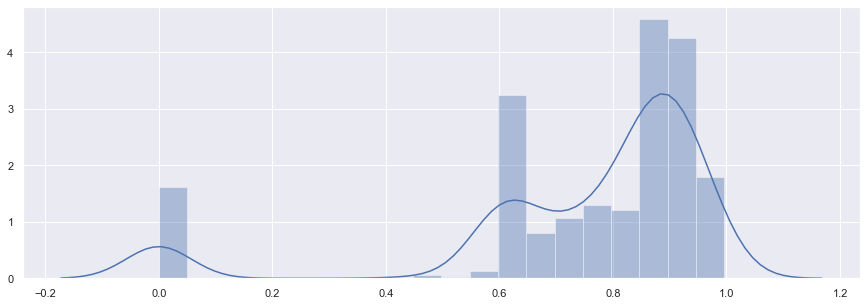

In [90]:
## Produce a 20-bin histogram to show the distribution of cosine similarity between node 9 and any other node in the graph (according to their recursive feature vectors)

import seaborn as sns, numpy as np
cos_sims = [item[1] for item in all_sims]

plt.figure(figsize=(15, 5))
ax = sns.distplot(cos_sims, bins=20, norm_hist=False)



In [145]:
def getBinCosSim(all_sims, bins, bin_index):
    ids = np.array([item[0] for item in all_sims])
    sims = np.array([item[1] for item in all_sims])
    bin_edges = np.array(range(bins))/bins
    bin_indice = np.digitize(sims, bin_edges)
    target_indice = np.argwhere(bin_indice==bin_index).ravel()
    return np.take(ids, target_indice)

getBinCosSim(all_sims, bins=20, bin_index=19)[:10]

array([ 0,  1,  2,  3,  4,  5,  6, 62, 63, 73])

In [157]:
all_sims_dict = { item[0]:item[1] for item in all_sims }
all_sims_dict[63]

0.9079028912111915

In [158]:
def getEgoSubGraph(nid, Graph):
    
    ego_node = Graph.GetNI(nid)
    
    NIdV = snap.TIntV()
    NIdV.Add(nid)
    for dstId in ego_node.GetOutEdges():
        NIdV.Add(dstId)    
    SubGraph = snap.GetSubGraph(G2, NIdV)
    return SubGraph  

subGraph = getEgoSubGraph(63, G2)

In [161]:
# draw subgraph

## 3 Community detection using the Louvain algorithm

### Phase 1 (Modularity Optimization): Start with each node in its own community.

### Phase 2 (Community Aggregation)

## 3.1 Modularity gain when an isolated node moves into a community [4 points]

## 3.2 Louvain algorithm on a 16 node network [10 points]

## 3.3 Louvain algorithm on a 128 node network [10 points]

## 3.4 What just happened? [1 point]

## 4 Spectral clustering [25 points]

## 4.1 A Spectral Algorithm for Normalized Cut Minimization: Foundations [10
points]

## 4.2 Normalized Cut Minimization: Solving for the Minimizer [8 points]

## 4.3 Relating Modularity to Cuts and Volumes [7 points]